# Channel Attribution Modelling

Every customer journey consists of a path of different channels/*touchpoints*.

The underlying concept to study the different *touchpoints* is known as *Channel Attribution Modelling*.

This is an example notebook using *Markov chains* in *R*.

In [36]:
# install.packages("magrittr")
library(magrittr) 
# install.packages("dplyr")
library(dplyr) 
# install.packages("ChannelAttribution")
library(ChannelAttribution)
# install.packages("viridis")
library(viridis)
# install.packages("reshape2")
library(reshape2)
# install.packages("markovchain")
library(markovchain)

## Read Data

For the purposes of this demonstration, the following channels were assumed:

- C1: patient got re-admitted to hospital
- C2 - patient got blood clot
- C3: patient had more surgery
- C4: patient dislocated joint

Patient journeys:

- C1 -> C4 -> C3 -> successful conversion (discharged)
- C1 -> C2 -> unsuccessful conversion (death)
- C3 -> C4 -> C2 -> unsuccessful conversion (death)
- C4 -> C3 -> successful conversion (discharged)
- C1 -> C3 -> succsessful conversion (discharged)

In [15]:
# Set Working Directory
setwd <- setwd('.')

# Read in CSV file containing patient journeys
df <- read.csv('patient_journeys.csv')

head(df)

patient_id journey                           conv conv_null
1 1          channel_1 > channel_4 > channel_3 1    0        
2 2          channel_1 > channel_2             0    1        
3 3          channel_3 > channel_4 > channel_2 0    1        
4 4          channel_4 > channel_3             1    0        
5 5          channel_1 > channel_3             1    0

## Calculate *Markov* Model

channel_from channel_to   transition_probability
1  (start)      channel_1    0.6000000             
2  (start)      channel_3    0.2000000             
3  (start)      channel_4    0.2000000             
4  channel_1    channel_4    0.3333333             
5  channel_1    channel_2    0.3333333             
6  channel_1    channel_3    0.3333333             
7  channel_4    channel_3    0.6666667             
8  channel_4    channel_2    0.3333333             
9  channel_3    (conversion) 0.7500000             
10 channel_3    channel_4    0.2500000             
11 channel_2    (null)       1.0000000

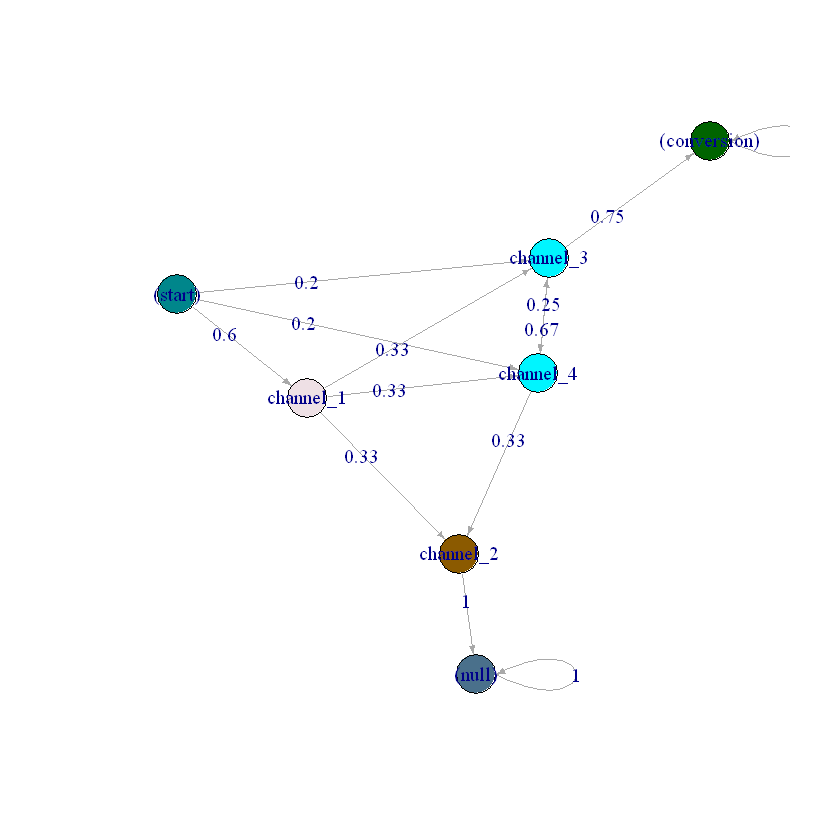

In [16]:
df1 = df%>%
  select(journey, conv, conv_null)

# calculating the model
mod1 <- markov_model(df1,
                    var_path = 'journey',
                    var_conv = 'conv',
                    var_null = 'conv_null',
                    out_more = TRUE)

# print the transition matrix
mod1$transition_matrix

# extracting the results of attribution
df_res1 <- mod1$result

# extracting a transition matrix
df_trans1 <- mod1$transition_matrix
df_trans1 <- dcast(df_trans1, channel_from ~ channel_to, value.var = 'transition_probability')

### plotting the Markov graph ###
df_trans <- mod1$transition_matrix

# adding dummies in order to plot the graph
df_dummy <- data.frame(channel_from = c('(start)', '(conversion)', '(null)'),
                       channel_to = c('(start)', '(conversion)', '(null)'),
                       transition_probability = c(0, 1, 1))
df_trans <- rbind(df_trans, df_dummy)
#df_trans

# ordering channels
df_trans$channel_from <- factor(df_trans$channel_from,
                                levels = c('(start)', '(conversion)', '(null)', 'channel_1', 'channel_2', 'channel_3','channel_4','channel_5'))
df_trans$channel_to <- factor(df_trans$channel_to,
                                levels = c('(start)', '(conversion)', '(null)', 'channel_1', 'channel_2', 'channel_3','channel_4','channel_5'))
df_trans <- dcast(df_trans, channel_from ~ channel_to, value.var = 'transition_probability')
#df_trans

# creating the markovchain object
trans_matrix <- matrix(data = as.matrix(df_trans[, -1]),
                       nrow = nrow(df_trans[, -1]), ncol = ncol(df_trans[, -1]),
                       dimnames = list(c(as.character(df_trans[, 1])), c(colnames(df_trans[, -1]))))
trans_matrix[is.na(trans_matrix)] <- 0
trans_matrix1 <- new("markovchain", transitionMatrix = trans_matrix)
 
# plotting the graph
my_cols = c("#e7f0fa", "#c9e2f6", "#95cbee", "#0099dc", "#4ab04a", "#ffd73e", "#eec73a")
plot(trans_matrix1, edge.arrow.size = 0.35, colors=my_cols)

The model calculates the *transition probability matrix* that shows the probability of transitioning from one channel to another for a given pair of channels.

The figure above shows the *transition probability matrix* and the *Markov* graph with the transition probabilities for each path.

Additionally, the model calculates the total convertions attributed to each channel, as shown below.

In [35]:
mod1$result

channel_name total_conversions
1 channel_1    0.7513434        
2 channel_4    0.7493455        
3 channel_3    1.4993111        
4 channel_2    0.0000000

Moreover, the *Markov chain* results show the *removal effect* for each channel.

*Removal effect* principle says that if we want to find the contribution of each channel in the patient journey, we can do so by removing each channel and see how many conversions are happening without that channel being in place.

For example, if we remove channel_1 (patient re-admitted to hospital) from the patient journeys we would loose 50% of the conversions, while removing channel_2 (patient got blood clot) would loose 49%.

In [34]:
# print the removal effect

mod1$removal_effect

channel_name removal_effects
1 channel_1    0.5011258      
2 channel_4    0.4997932      
3 channel_3    1.0000000      
4 channel_2    0.0000000